### Exercise 2.4
Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the q*(a) start out equal and then take independent random walks (say by adding a normally distribured increment with mean zero and standard deviation 0.01 to all the q*(a) on each step). Prepare plots like Figure 2.2 for an action-value method using smaple averages, incrementally computed, and another action-value method using a constant step-size parameter, alpha = 0.1, use e=0.1 and longer runs, say of 10000 steps

### Creating k-Armed Bandit

In [144]:
import random
import numpy as np

class Bandit():
    def __init__(self, k):
        self.k = k                                     # Number of bandits
        self.k_rewards = np.zeros(k)                   # Reward buffer with mean 0

    def get_optimal_action(self):
        return np.argmax(self.k_rewards)

    def step(self, action_k):
        to_return = self.k_rewards[action_k]
        self.k_rewards += np.random.uniform(-0.018, 0.018, size=self.k)   # Approximate stdev of 0.01
        return to_return

class Agent():
    def __init__(self, bandit, action_value="ave", step_size=0.1, epsilon=0.1, est_reward=None):
        self.bandit = bandit                   # bandit to learn
        self.k = bandit.k                      # k derived from the bandit
        self.action_value = action_value       # type of action value. supports "ave", "inc"
        self.step_size = step_size             # decay rate
        self.epsilon = epsilon                 # exploration weight
        self.t = 0                             # time increment
        self.est_reward = np.zeros(bandit.k)   # estimated rewards for all k actions
        if est_reward:
            self.est_reward += est_reward
        
        # METRICS
        self.optimal_actions = 0
        self.average_reward = 0
    
    def step(self):
        # Increment time-step
        self.t += 1
        
        # Chooses random action if r < epsilon
        if random.uniform(0, 1) < self.epsilon:
            action_k = random.randint(0, self.k - 1)
        else:
            action_k = np.argmax(self.est_reward)
        
        # Keeps running tab on optimal action count
        self.optimal_actions += (action_k == self.bandit.get_optimal_action())
        
        # Take a single step, recieve reward
        reward = self.bandit.step(action_k)
        
        # Compute running average reward
        self.average_reward = ((self.average_reward * (self.t - 1)) + reward) / self.t

        # Update estimated reward based on set action_value
        if self.action_value == "ave":
            self.est_reward[action_k] += ((1. / self.t) * (reward - self.est_reward[action_k]))
        elif self.action_value == "inc":
            self.est_reward[action_k] += (self.epsilon * (reward - self.est_reward[action_k]))
    
    def nstep(self, n):
        for i in range(n):
            self.step()

In [217]:
%matplotlib notebook
import matplotlib.pyplot as pp

a_ave = Agent(bandit=Bandit(k=10), action_value="ave")
a_inc = Agent(bandit=Bandit(k=10), action_value="inc")

a_ave_optimal = []
a_ave_average = []

a_inc_optimal = []
a_inc_average = []

t_axis = []
t = 0
nstep = 10
for i in range(1000):
    
    a_ave.nstep(nstep)
    a_inc.nstep(nstep)
    
    t += nstep
    t_axis.append(t)
    
    a_ave_optimal.append(a_ave.optimal_actions / t)
    a_ave_average.append(a_ave.average_reward)
    
    a_inc_optimal.append(a_inc.optimal_actions / t)
    a_inc_average.append(a_inc.average_reward)

## Evaluating Incremental vs Average Action Value
It is apparent the incremental action value performs better than average action value. It is able to adapt to the nonstationary reward, whereas average's  estimated reward converges and rarely moves despite the actual rewards moving.

<IPython.core.display.Javascript object>


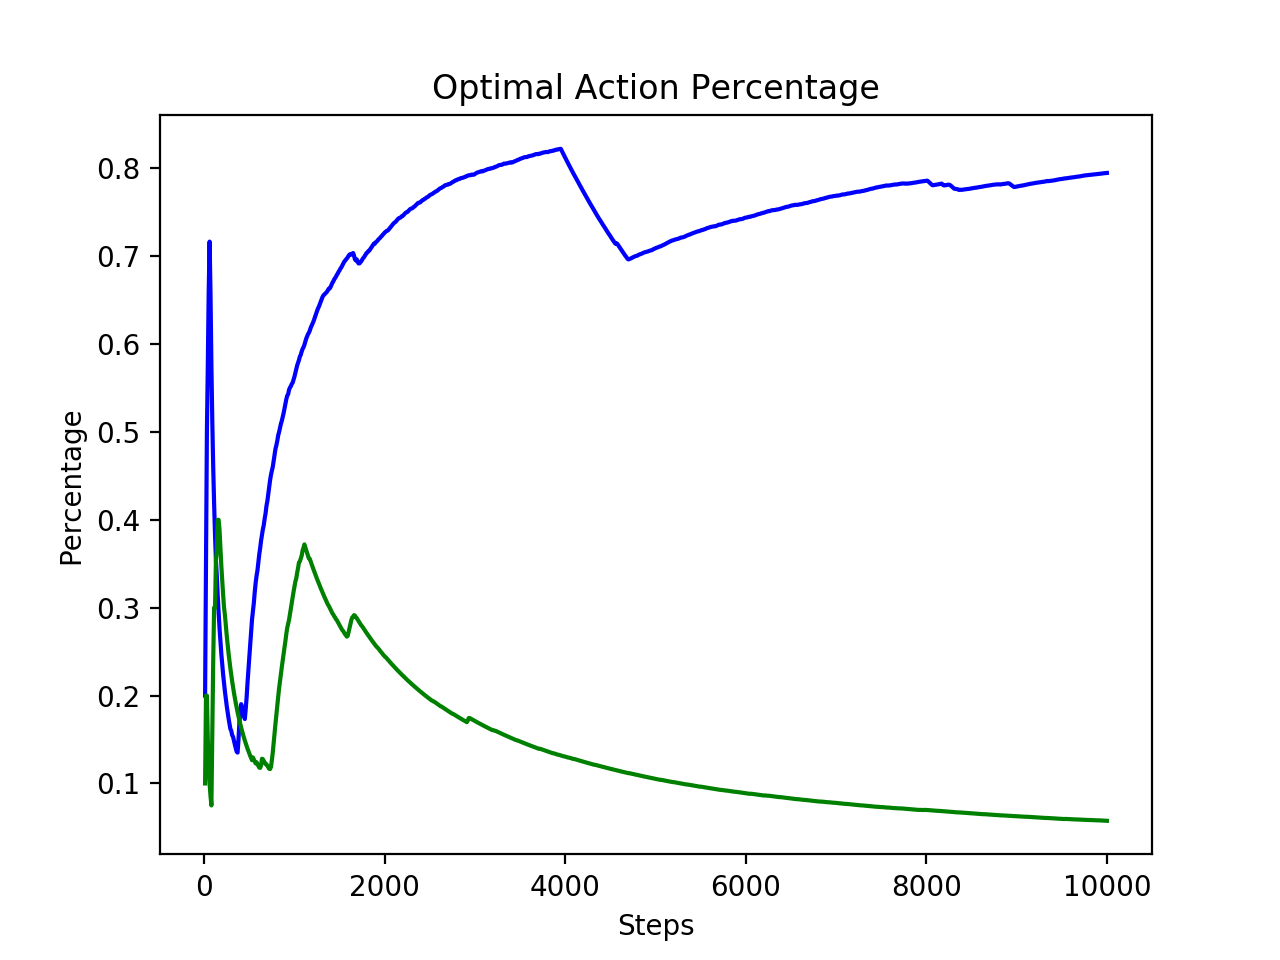

In [218]:
pp.figure(0) # Here's the part I need
pp.title("Optimal Action Percentage")
pp.xlabel("Steps")
pp.ylabel("Percentage")
pp.plot(t_axis, a_inc_optimal, 'b', label='Incremental')
pp.plot(t_axis, a_ave_optimal, 'g', label='Average')

<IPython.core.display.Javascript object>


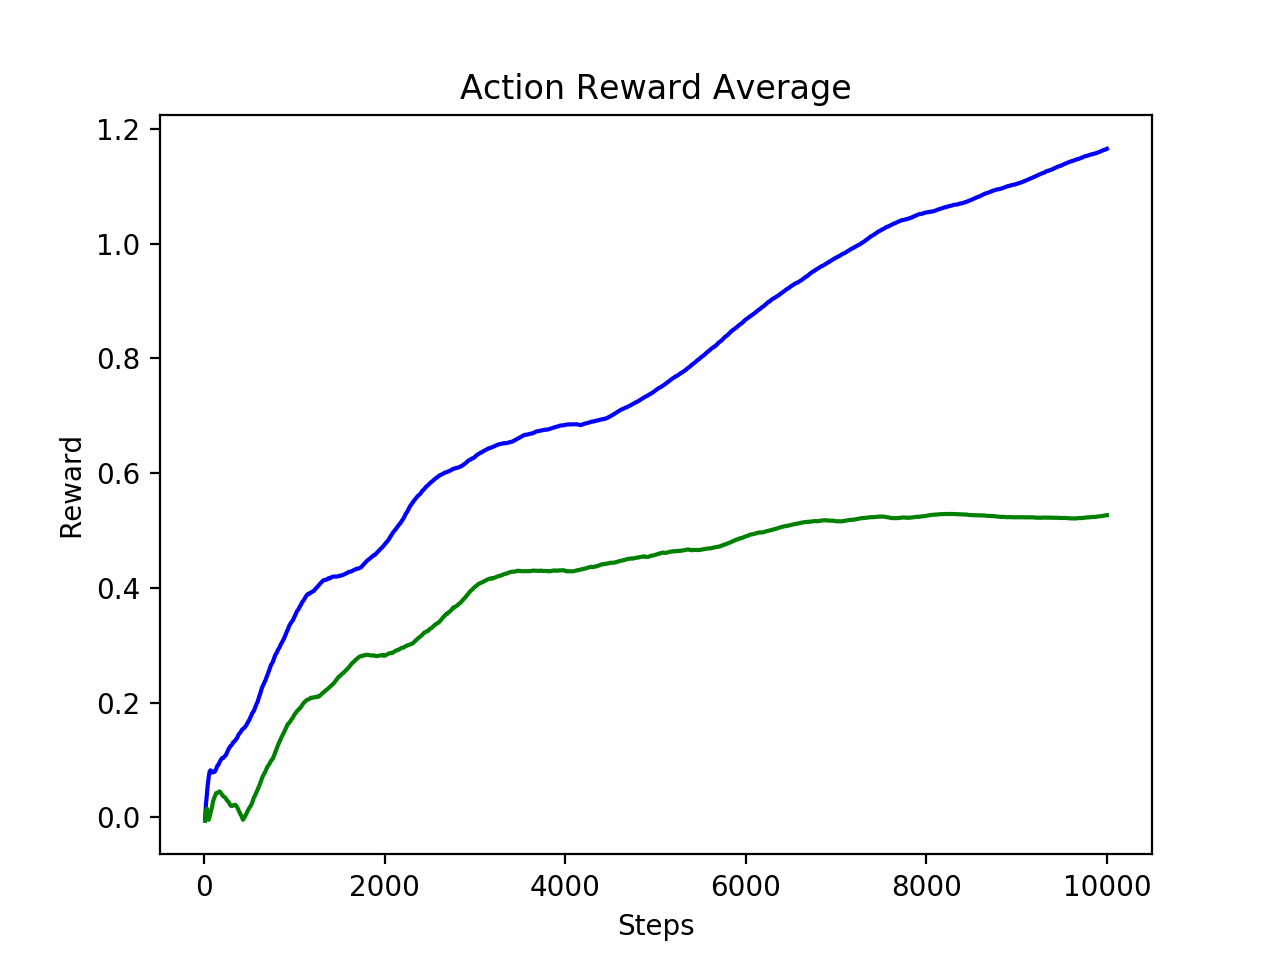

In [219]:
pp.figure(1) # Here's the part I need
pp.title("Action Reward Average")
pp.xlabel("Steps")
pp.ylabel("Reward")
pp.plot(t_axis, a_inc_average, 'b', label='Incremental')
pp.plot(t_axis, a_ave_average, 'g', label='Average')